In [54]:
#LSTM multi-price input
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(threshold=np.nan)

In [41]:
# load price data
df = pd.read_table('./processed_may5may9.csv', sep=',')
df.head()

,timestamp,last
0,2018-05-05 23:00:00,9796.99
1,2018-05-06 00:00:00,9823.28
2,2018-05-06 01:00:00,9890.51
3,2018-05-06 02:00:00,9894.99
4,2018-05-06 03:00:00,9830.99


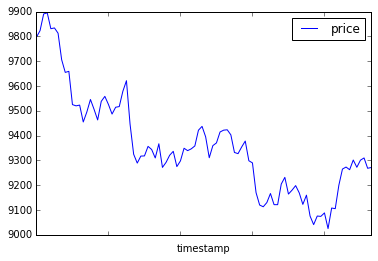

In [75]:
df.plot(x='timestamp', y='last', label='price')
# savefig('price.jpg')

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [18]:
values = df['last'].values
values

array([9796.99, 9823.28, 9890.51, 9894.99, 9830.99, 9834.11, 9813.  ,
       9706.16, 9654.84, 9659.13, 9525.  , 9519.97, 9522.99, 9454.96,
       9495.27, 9545.69, 9506.15, 9463.2 , 9538.09, 9558.22, 9525.49,
       9486.82, 9514.38, 9516.99, 9578.53, 9621.39, 9446.55, 9324.88,
       9289.19, 9317.42, 9318.  , 9356.53, 9344.02, 9309.79, 9367.05,
       9271.73, 9292.  , 9320.73, 9336.57, 9275.  , 9298.08, 9349.  ,
       9339.37, 9346.61, 9358.3 , 9421.73, 9437.17, 9395.  , 9310.74,
       9359.52, 9370.51, 9414.56, 9421.98, 9423.44, 9402.97, 9332.01,
       9327.27, 9353.92, 9378.  , 9298.6 , 9289.96, 9170.02, 9120.  ,
       9113.06, 9130.  , 9166.52, 9121.56, 9121.51, 9204.62, 9231.65,
       9164.32, 9180.  , 9198.39, 9168.99, 9122.62, 9159.81, 9075.74,
       9041.  , 9075.69, 9074.3 , 9088.3 , 9024.99, 9107.92, 9105.4 ,
       9199.77, 9265.  , 9273.24, 9262.4 , 9301.51, 9272.3 , 9300.94,
       9309.92, 9268.24, 9271.31])

In [24]:
values = values.astype('float32') # convert to float
values = values.reshape((values.shape[0], -1))
values

array([[9796.99],
       [9823.28],
       [9890.51],
       [9894.99],
       [9830.99],
       [9834.11],
       [9813.  ],
       [9706.16],
       [9654.84],
       [9659.13],
       [9525.  ],
       [9519.97],
       [9522.99],
       [9454.96],
       [9495.27],
       [9545.69],
       [9506.15],
       [9463.2 ],
       [9538.09],
       [9558.22],
       [9525.49],
       [9486.82],
       [9514.38],
       [9516.99],
       [9578.53],
       [9621.39],
       [9446.55],
       [9324.88],
       [9289.19],
       [9317.42],
       [9318.  ],
       [9356.53],
       [9344.02],
       [9309.79],
       [9367.05],
       [9271.73],
       [9292.  ],
       [9320.73],
       [9336.57],
       [9275.  ],
       [9298.08],
       [9349.  ],
       [9339.37],
       [9346.61],
       [9358.3 ],
       [9421.73],
       [9437.17],
       [9395.  ],
       [9310.74],
       [9359.52],
       [9370.51],
       [9414.56],
       [9421.98],
       [9423.44],
       [9402.97],
       [93

In [25]:
values.shape

(94, 1)

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) # normalised
reframed = series_to_supervised(scaled, 3, 1)
reframed

,var1(t-3),var1(t-2),var1(t-1),var1(t)
3,0.887356,0.917574,0.994849,1.000000
4,0.917574,0.994849,1.000000,0.926436
5,0.994849,1.000000,0.926436,0.930023
6,1.000000,0.926436,0.930023,0.905758
7,0.926436,0.930023,0.905758,0.782953
8,0.930023,0.905758,0.782953,0.723965
9,0.905758,0.782953,0.723965,0.728896
10,0.782953,0.723965,0.728896,0.574723
11,0.723965,0.728896,0.574723,0.568941
12,0.728896,0.574723,0.568941,0.572413


In [28]:
# train and test set
split = 0.9
reframed_values = reframed.values
train = reframed_values[:int(len(reframed_values)*split), :]
test = reframed_values[int(len(reframed_values)*split):, :]
test.shape

(10, 4)

In [32]:
train.shape

(81, 4)

In [56]:
# split into input output
trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [57]:
trainX.shape

(81, 1, 3)

In [58]:
# LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]))) # LSTM layer, 100 units
model.add(Dense(1)) # fully connected layer
model.compile(loss='mae', optimizer='adam') # configure training process, mean absolute error

In [59]:
# iterate training batches
history = model.fit(trainX, trainY, epochs=50, batch_size=5, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 81 samples, validate on 10 samples
Epoch 1/50
 - 1s - loss: 0.3012 - val_loss: 0.1513
Epoch 2/50
 - 0s - loss: 0.1883 - val_loss: 0.0406
Epoch 3/50
 - 0s - loss: 0.1112 - val_loss: 0.0324
Epoch 4/50
 - 0s - loss: 0.0799 - val_loss: 0.0293
Epoch 5/50
 - 0s - loss: 0.0721 - val_loss: 0.0303
Epoch 6/50
 - 0s - loss: 0.0675 - val_loss: 0.0333
Epoch 7/50
 - 0s - loss: 0.0641 - val_loss: 0.0355
Epoch 8/50
 - 0s - loss: 0.0607 - val_loss: 0.0379
Epoch 9/50
 - 0s - loss: 0.0575 - val_loss: 0.0431
Epoch 10/50
 - 0s - loss: 0.0570 - val_loss: 0.0445
Epoch 11/50
 - 0s - loss: 0.0549 - val_loss: 0.0479
Epoch 12/50
 - 0s - loss: 0.0553 - val_loss: 0.0472
Epoch 13/50
 - 0s - loss: 0.0558 - val_loss: 0.0486
Epoch 14/50
 - 0s - loss: 0.0552 - val_loss: 0.0458
Epoch 15/50
 - 0s - loss: 0.0558 - val_loss: 0.0528
Epoch 16/50
 - 0s - loss: 0.0556 - val_loss: 0.0446
Epoch 17/50
 - 0s - loss: 0.0556 - val_loss: 0.0461
Epoch 18/50
 - 0s - loss: 0.0544 - val_loss: 0.0453
Epoch 19/50
 - 0s - loss: 0.0

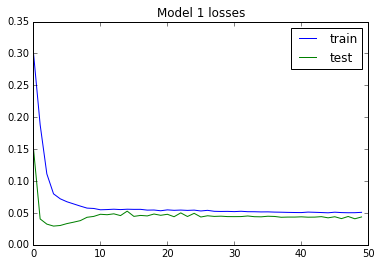

In [133]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Model 1 losses')
plt.savefig('loss.jpg')
plt.show()

In [64]:
model.save("./price_only_model") # save model

In [65]:
yhat = model.predict(testX)
yhat

array([[0.09117761],
       [0.1670941 ],
       [0.2279532 ],
       [0.26523292],
       [0.272649  ],
       [0.29762083],
       [0.2843669 ],
       [0.3048261 ],
       [0.31083077],
       [0.2909744 ]], dtype=float32)

In [67]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat

array([[9104.315],
       [9170.362],
       [9223.31 ],
       [9255.743],
       [9262.195],
       [9283.921],
       [9272.39 ],
       [9290.189],
       [9295.414],
       [9278.139]], dtype=float32)

In [71]:
testY_reshape = testY.reshape((len(testY), -1))
inv_testY = scaler.inverse_transform(testY_reshape)
inv_testY

array([[9199.77],
       [9265.  ],
       [9273.24],
       [9262.4 ],
       [9301.51],
       [9272.3 ],
       [9300.94],
       [9309.92],
       [9268.24],
       [9271.31]], dtype=float32)

In [72]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_testY, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 49.270


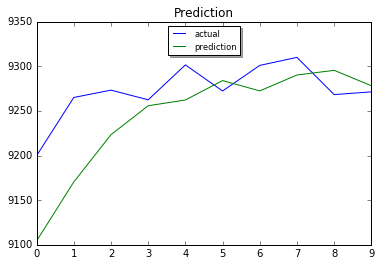

In [74]:
plt.plot(inv_testY, label='actual')
plt.plot(inv_yhat, label='prediction')
plt.title('Prediction')
plt.legend(loc='upper center', shadow=True, fontsize='small')
plt.savefig('prediction.jpg')
plt.show()

In [103]:
dfy = pd.DataFrame(inv_yhat)
dfy.index = range(84,94)
dfy

,0
84,9104.315430
85,9170.362305
86,9223.309570
87,9255.743164
88,9262.195312
89,9283.920898
90,9272.389648
91,9290.189453
92,9295.414062
93,9278.138672


In [127]:
dfc = pd.concat([df, dfy], axis=1)
# dfc = dfc.replace(np.nan, '', regex=True)
dfc['last'] = dfc['last'].astype('float32')
dfc.columns = ['time', 'price', 'prediction']
dfc

,time,price,prediction
0,2018-05-05 23:00:00,9796.990234,NaN
1,2018-05-06 00:00:00,9823.280273,NaN
2,2018-05-06 01:00:00,9890.509766,NaN
3,2018-05-06 02:00:00,9894.990234,NaN
4,2018-05-06 03:00:00,9830.990234,NaN
5,2018-05-06 04:00:00,9834.110352,NaN
6,2018-05-06 05:00:00,9813.000000,NaN
7,2018-05-06 06:00:00,9706.160156,NaN
8,2018-05-06 07:00:00,9654.839844,NaN
9,2018-05-06 08:00:00,9659.129883,NaN


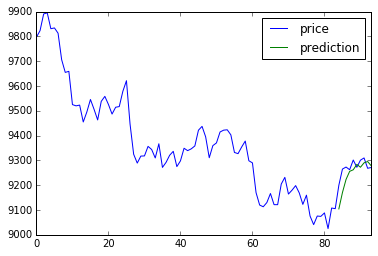

In [132]:
plot = dfc.plot(y=["price","prediction"], label='price')
fig = plot.get_figure()
fig.savefig('sprediction.jpg')
